In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
df = pd.read_csv('time_series_covid19_confirmed_global_20200917.csv')

In [3]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,26779,27363,27919,28664,29256,29906,30574,31362,32250,33006
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1989,1994,1999,2003,2007,2009,2011,2013,2016,2019
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,12836,12952,13112,13214,13323,13466,13539,13720,13819,13887


In [4]:
# 日本のデータのみ抽出する
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20
151,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,...,72213,72724,73264,73916,74558,75206,75646,75914,76446,76997


In [5]:
# ５項目目以降（1/22以降）の項目のみにする
df = df.iloc[:,4:].copy()
#１行目の項目を取得
daily_japan=df.iloc[0,:]
# 日付型に変換
daily_japan.index = pd.to_datetime(daily_japan.index)

In [6]:
daily_japan

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-09-12    75206
2020-09-13    75646
2020-09-14    75914
2020-09-15    76446
2020-09-16    76997
Name: 151, Length: 239, dtype: int64

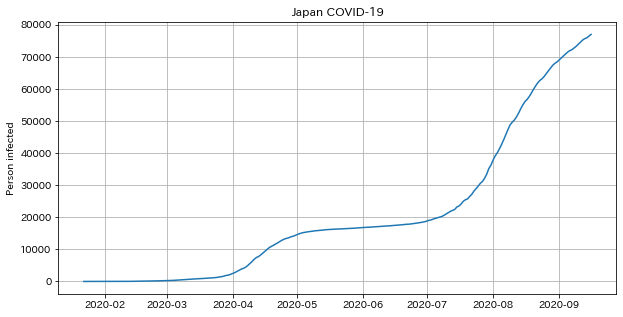

In [7]:
# 日本の感染者数のグラフ
plt.figure(figsize=(10,5))
plt.plot(daily_japan)
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.show()

In [8]:
y=daily_japan.values.astype(float)

In [9]:
# 時系列データを７日をひとつのくくりとして、まとめる。
# ８日目を正解ラベル
def sequence_creator(input_data,window):
    dataset=[]
    data_len = len(input_data)
    for i in range(data_len - window):
        window_fr = input_data[i:i+window]
        label = input_data[i+window:i+window+1]
        dataset.append((window_fr,label))
    return dataset

In [10]:
# LSTMのモデリング
class LSTM_COVID(nn.Module):
    # in_size  ： 入力のノードのサイズ
    # h_size   : 隠れ層のノードのサイズ　（誤差が少なくなるように調整する項目）
    # out_size : 結果のノードのサイズ
    def __init__(self, in_size=1, h_size=30, out_size=1):
        super().__init__()
        
        self.h_size = h_size
        self.lstm = nn.LSTM(in_size, h_size)
        self.fc = nn.Linear(h_size,out_size)
        
        self.hidden = (torch.zeros(1,1,self.h_size), torch.zeros(1,1,self.h_size))
        
    def forward(self, sequence_data):
        lstm_out, self.hidden = self.lstm(sequence_data.view(len(sequence_data),1,-1),self.hidden)
        pred = self.fc(lstm_out.view(len(sequence_data),-1))
        return pred[-1]

# モデルの定義

In [11]:
torch.manual_seed(3)

model = LSTM_COVID()
criterion = nn.MSELoss()
# lr : lrlearning rate)=学習率　どれぐらいの幅でパラメータを更新していくのか（誤差が少なくなるように調整する項目）
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [12]:
window_size = 7
loss_list = []
loss_temp = 0

#model.train()

In [13]:
# 入力の正規化 (-1 から1に収まるように)
scaler = MinMaxScaler(feature_range=(-1,1))
y_normalized = scaler.fit_transform(y.reshape(-1,1))
y_normalized = torch.FloatTensor(y_normalized).view(-1)
full_data = sequence_creator(y_normalized,window_size)

# トレーニング

In [14]:
# 学習の繰り返し
epochs = 300
for epoch in range(epochs):
    # トレーニングデータの件数分ループする
    for sequence_in, y_train in full_data:
        # 予測値計算
        y_pred = model(sequence_in)
        # 損失計算
        loss = criterion(y_pred, y_train)
        loss_temp += loss
        # 勾配を初期化する
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        # パラメータを更新する
        loss.backward()
        optimizer.step()
        
    if((epoch+1) % 10 ==0):
        loss_list.append(loss_temp.item()/(10*len(full_data)))
        print(f'Epoch {epoch+1} Loss {loss_temp.item()/(10*len(full_data))}')
        loss_temp = 0


Epoch 10 Loss 0.022692287379297717
Epoch 20 Loss 0.0038627550519745924
Epoch 30 Loss 0.0024093954727567478
Epoch 40 Loss 0.001665615727161539
Epoch 50 Loss 0.002019373507335268
Epoch 60 Loss 0.002385064651226175
Epoch 70 Loss 0.0022212155934037835
Epoch 80 Loss 0.0017118517694802119
Epoch 90 Loss 0.0013016874420231786
Epoch 100 Loss 0.0010061215737770344
Epoch 110 Loss 0.0008215937634994244
Epoch 120 Loss 0.0007062323648354103
Epoch 130 Loss 0.0006180135854359331
Epoch 140 Loss 0.0005501898712125318
Epoch 150 Loss 0.0004975205865399591
Epoch 160 Loss 0.0004494272943200736
Epoch 170 Loss 0.00040549879957889687
Epoch 180 Loss 0.00036246242194340147
Epoch 190 Loss 0.00032679911317496464
Epoch 200 Loss 0.00029863566160202024
Epoch 210 Loss 0.0002777837987603812
Epoch 220 Loss 0.0002625056638799865
Epoch 230 Loss 0.0002480365335941315
Epoch 240 Loss 0.00023695618428032974
Epoch 250 Loss 0.00022713012736419152
Epoch 260 Loss 0.00018048204224685143
Epoch 270 Loss 0.00015364258453763764
Epoch 

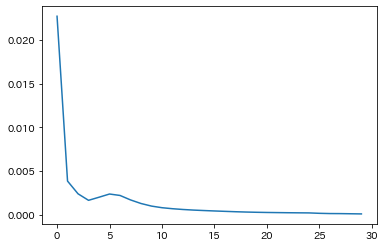

In [15]:
# ロスのプロット
plt.plot(loss_list)

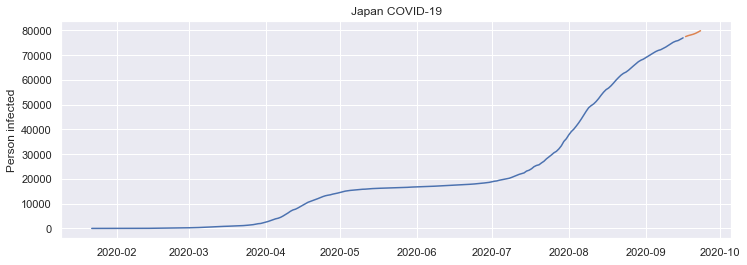

In [17]:
# 将来の７日間の予測
upcoming_future = 7
predictions = y_normalized[-window_size:].tolist()

model.eval()

for i in range(upcoming_future):
    sequence = torch.FloatTensor(predictions[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.h_size),torch.zeros(1,1,model.h_size))
        predictions.append(model(sequence).item())
        
predictions_y = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
# 7/22　～　7/28 まで（７日間）の予測値を指定する
x = np.arange('2020-09-17','2020-09-24', dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
plt.figure(figsize = (12,4))
plt.title("Japan COVID-19")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(daily_japan)
plt.plot(x,predictions_y[-window_size:])
plt.show()

In [18]:
# 予測値
predictions_y[-window_size:]

array([[77506.76578057],
       [77882.31407416],
       [78155.47598553],
       [78435.52637559],
       [78815.98058772],
       [79315.95288825],
       [79870.05550605]])